# <span style='color:purple'>Lab 2 - GridSearchCV for Random Forest Only</span>


# <span style='color:blue'>Data Preparation (15 points total)</span>
* Sample 15,000 rows of data to speed up the GridSearchCV function, then use those results on the full dataset

In [1]:
# set up environment and load dataset

import numpy as np
import pandas as pd
import os
from datetime import datetime as dt
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt

# set working directory
os.chdir(r"C:\Users\justi\GitHub\olist\data")
print('Current working directory:',os.getcwd())

# Let's get the data
olist_download = pd.read_csv('olist_lab1_data.csv')  
print(olist_download.shape)
#olist_download.head()

Current working directory: C:\Users\justi\GitHub\olist\data
(114067, 47)


In [28]:
grids = copy.deepcopy(olist_download) # so now we have a back up of the original dataset

## <span style='color:red'>Define class variable representations (int,float, onehot, etc)</span>

In [29]:
# clean up attributes in the relaoded dataset from lab 1

#changing attributes data types
continuous_features = ['price','freight_value', 'payment_sequential','payment_installments','payment_value',
                      'product_name_length','product_description_length', 'product_photos_qty','product_weight_g',
                      'product_length_cm','product_height_cm','product_width_cm', 'review_score'] 

cat_features = ['customer_city','customer_state','customer_zip_code_prefix','seller_zip_code_prefix',
                'seller_city','seller_state','product_category_english','review_id','review_comment_title',
                'review_comment_message','payment_type','order_item_id', 'product_id','seller_id','order_id', 
                'customer_id','customer_unique_id','delivery_est_discrepancy_range','purchase_month','purchase_wk_day',
                'review_score_class'] 

date_features = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                 'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 


In [30]:
# use the "astype" function to change the variable type

grids[cat_features] = grids.copy()[cat_features].astype('category')

grids[continuous_features] = grids.copy()[continuous_features].astype(np.float64)


In [31]:
# fix dates

for i in date_features:
    grids.loc[:,i] = pd.to_datetime(grids.copy().loc[:,i], errors="coerce")

In [32]:
#grids.info()

In [33]:
print(grids.duplicated().sum())

0


In [34]:
# let's remove nominal values (anything with the label x_id) and anything with possible NaNs such as the comments
grids = grids.drop(columns = ['review_comment_title','review_comment_message','review_id','order_id','customer_id',
                              'order_item_id','product_id','seller_id','customer_unique_id','product_length_cm',
                              'product_width_cm','product_height_cm','payment_value','delivery_estimate_discrepancy',
                              'delivery_est_discrepancy_range','order_delivery_actual_duration',
                              'order_delivery_estimated_duration', 'order_approved_at','order_delivered_carrier_date',
                              'order_delivered_customer_date','order_estimated_delivery_date',
                              'review_creation_date','review_answer_timestamp','shipping_limit_date','purchase_wk_day'],
                   axis=1) 


In [35]:
print(grids.duplicated().sum())
# looks like removing those columns made it look like we have duplicates, to keep from overfitting the model
# we  will go ahead and remove those
grids.drop_duplicates(inplace=True)
print(grids.duplicated().sum())

10735
0


In [36]:
missing = grids[grids.product_weight_g.isna()].index.values.tolist()[0]
print('Index %d is missing values in product_weight and product_dimensions' % (missing))
grids = grids.drop(index = missing, axis=0)

print('We now have %d records missing values' % (grids.isna().any().sum()))

Index 40711 is missing values in product_weight and product_dimensions
We now have 0 records missing values


In [37]:
# change purchase date into year, day, month and hour so that's numeric

grids['purchase_year'] = grids.order_purchase_timestamp.dt.year
grids['purchase_month'] = grids.order_purchase_timestamp.dt.month
grids['purchase_day'] = grids.order_purchase_timestamp.dt.dayofweek
grids['purchase_hour'] = grids.order_purchase_timestamp.dt.hour

grids.drop(columns = ['order_purchase_timestamp'], axis=1, inplace=True)


In [12]:
# export to pickle

#grids.to_pickle('olist_justin_gridsearch.pkl')

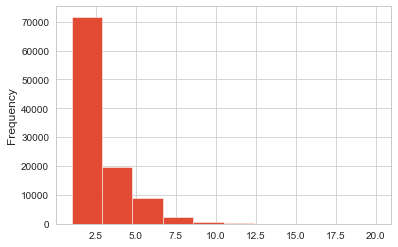

In [38]:
# determine best binning for product_description_length
import seaborn as sns
sns.set_style('whitegrid')

grids.product_photos_qty.plot(kind='hist')
plt.show()

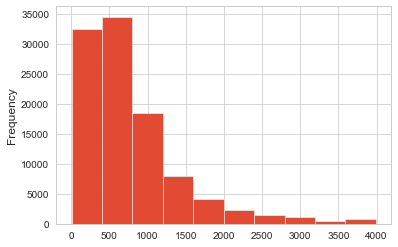

In [39]:
grids.product_description_length.plot(kind='hist')
plt.show()

---
#### <span style='color:red'>Sample from Grids for GridSearchCV on RandomForestClassifier</span>
---

In [40]:
# make a copy of grids for running the randomforestclassifier with the whole dataset
random = copy.deepcopy(grids)

---
## <span style='color:orange'> Sample Down to 15,000 records </span>
---

In [44]:
grids = grids.sample(n=15000, random_state=42)
grids.shape

(15000, 24)

In [45]:
# remove the response variable - payment_method
grids_y = copy.deepcopy(grids.payment_type)
grids_X = copy.deepcopy(grids.drop(columns=['payment_type']))

print('\n=====================Shapes=====================\n')
print('Original dataset shape:', grids.shape)
print('X shape:', grids_X.shape)
print('y shape:', grids_y.shape)





=====================Shapes=====================

Original dataset shape: (15000, 24)
X shape: (15000, 23)
y shape: (15000,)


##### StratifiedShuffleSplit Train/Test
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html?highlight=stratifiedshufflesplit#sklearn.model_selection.StratifiedShuffleSplit

In [46]:
list(grids_X)

['customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'review_score',
 'payment_sequential',
 'payment_installments',
 'price',
 'freight_value',
 'product_name_length',
 'product_description_length',
 'product_photos_qty',
 'product_weight_g',
 'product_category_english',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'tot_order_amt',
 'purchase_month',
 'review_score_class',
 'product_dimensions',
 'purchase_year',
 'purchase_day',
 'purchase_hour']

In [48]:
# train/ test split
from sklearn.model_selection import StratifiedShuffleSplit
X = grids_X
y = grids_y
cv = StratifiedShuffleSplit(n_splits=1,test_size = 0.3, train_size = 0.7, random_state=42) #note default is 10 splits!

np.random.seed(42)

print(cv)
print(cv.get_n_splits(X,y))

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(X,y):
    # using a dataframe we need to reference the rows using pd.iloc[] notation
    # if we were using a numpy array or sparse matrix, we would be able to just use X[<index>]
    X_train, X_test = X.iloc[trainidx], X.iloc[testidx] 
    y_train, y_test = y.iloc[trainidx], y.iloc[testidx]


StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=0.7)
1


In [49]:
print(X.shape)
print(y.shape)
print('Let\'s take a look at how our training/ test splits came out:')
print(cv,'\nn_splits:',cv.get_n_splits(X,y))
print('X_train.shape:',X_train.shape, 'X_test.shape:',X_test.shape)
print('y_train.shape:',y_train.shape, 'y_test.shape:',y_test.shape)


(15000, 23)
(15000,)
Let's take a look at how our training/ test splits came out:
StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=0.7) 
n_splits: 1
X_train.shape: (10500, 23) X_test.shape: (4500, 23)
y_train.shape: (10500,) y_test.shape: (4500,)


##### <span style='color:red'><b>SelectKBest Feature Selection</b></span>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html?highlight=featureunion#sklearn.pipeline.FeatureUnion
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html?highlight=functiontransformer#sklearn.preprocessing.FunctionTransformer

In [52]:
# use SelectKBest from Sklearn to get an idea of best features
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import GridSearchCV

np.random.seed(42)

numeric = list(X_train.select_dtypes(include=['float64','int64']).columns)
categorical = list(X_train.select_dtypes('category'))

# categorical column selector
ordinal = Pipeline([('selector_cat', FunctionTransformer(lambda train: train.loc[:,categorical])), 
                    ('enc', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=-1))])

# numerical column selector
scaler = Pipeline([('selector_num', FunctionTransformer(lambda train: train.loc[:,numeric])), 
                    ('standscale', StandardScaler())])

# join the columns backtogether
features = FeatureUnion([("ordinal", ordinal),
                             ("scaler", scaler)])
preprocessor = Pipeline([('features', features),
                         ('minmax', MinMaxScaler())])

preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# convert the resonse variables into numeric values using LabelEncoder 
le = LabelEncoder()
le.fit(y_train)
y_train_proc = le.transform(y_train)
y_test_proc = le.transform(y_test)

skb = SelectKBest(chi2, k=11)  
skb.fit(X_train_proc,y_train_proc)
X_train_feats = skb.transform(X_train_proc)
X_test_feats = skb.transform(X_test_proc)

# create a dataframe matching feature names to chi^2 scores
cols = np.array(X.columns)
pd.options.display.float_format = '{:.2f}'.format # remove that pesky scientific notation
feat_scores = pd.DataFrame({'feature':cols, 'score':skb.scores_, 'p_values': skb.pvalues_})

# sort by score values in descending order
feat_scores.sort_values(by = ['score'], axis=0, ascending=False, inplace=True, ignore_index=True)

# print out feature chi^2 scores
print(feat_scores)

                       feature  score  p_values
0   product_description_length 764.25      0.00
1           product_photos_qty 300.41      0.00
2     customer_zip_code_prefix   6.46      0.09
3                purchase_year   4.45      0.22
4                 purchase_day   2.99      0.39
5                 review_score   2.35      0.50
6                tot_order_amt   2.23      0.53
7                purchase_hour   1.92      0.59
8           payment_sequential   1.91      0.59
9         payment_installments   1.70      0.64
10              customer_state   1.51      0.68
11            product_weight_g   1.34      0.72
12              purchase_month   1.25      0.74
13          product_dimensions   0.83      0.84
14                seller_state   0.66      0.88
15                 seller_city   0.61      0.89
16          review_score_class   0.60      0.90
17               freight_value   0.39      0.94
18         product_name_length   0.38      0.94
19    product_category_english   0.26   

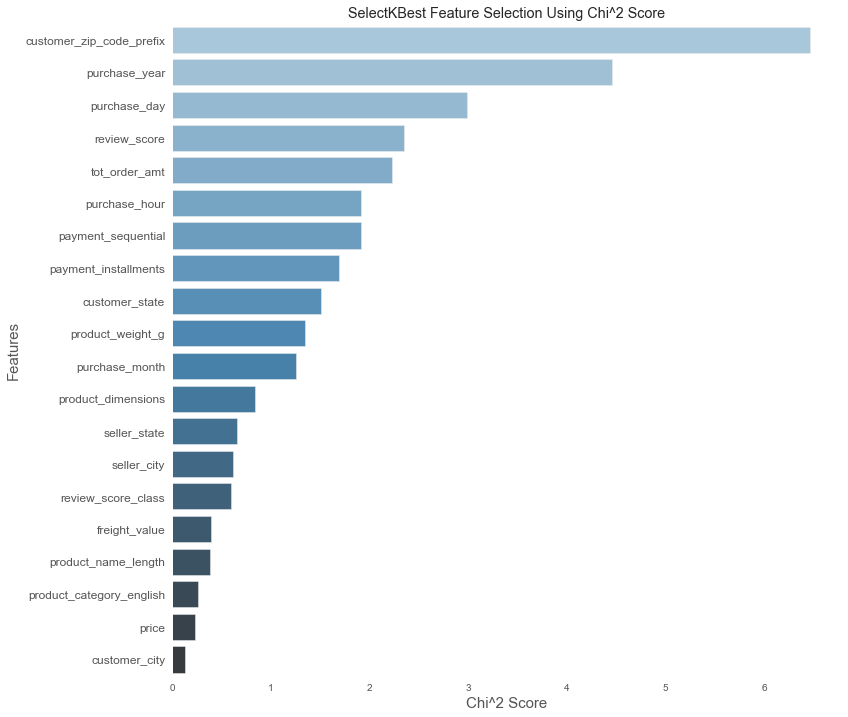

In [53]:
# let's also plot the scores to get a visual sense of what features are deemed most important
from matplotlib import pyplot

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,12))

ft = feat_scores.feature[2:22] # leaving out the crazy chi2 scores
chiscore = feat_scores.score

ax = sns.barplot(x=chiscore, y=ft, palette='Blues_d')
#ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # add commas in the x axis numbers
ax.set_facecolor('white')
ax.set_yticklabels(ft, size=12)

plt.title('SelectKBest Feature Selection Using Chi^2 Score')
plt.ylabel('Features', size=15)
plt.xlabel('Chi^2 Score', size=15)
plt.show()



#Note I want to keep the top 10, so we will rerun this using k=15 to get our X_train_feats/ X_test_feats with 10 features

### <span style='color:blue'>Model Selection Random Forest with reduced features tuned with GridSearch</span>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



# code adopted from:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

parameters = {'n_estimators':[100,150,200],
              'criterion':['gini','entropy'],
              'min_samples_split' : [2,10,25],
              'min_samples_leaf': [1,5,10],
              'max_features': [2,3,5]}
   

gs = GridSearchCV(rfc, param_grid = parameters, cv=10)

gs.fit(X_train_feats, y_train_proc)


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [2, 3, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 25],
                         'n_estimators': [100, 150, 200]})

In [55]:
from joblib import dump, load

best_params = gs.best_params_
print(type(best_params))
print(best_params)

# save parameters

dump(gs.best_params_, 'best_params_RandomForestClassifier.joblib', )

<class 'dict'>
{'criterion': 'gini', 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 25, 'n_estimators': 200}


['best_params_RandomForestClassifier.joblib']

In [56]:
# how long did that gridsearchcv take?

mean_fit_time= gs.cv_results_['mean_fit_time']
mean_score_time= gs.cv_results_['mean_score_time']
n_splits  = gs.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(gs.cv_results_).shape[0] #Iterations per split
minutes = (np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)/60
print('The GridSearchCV too %f minutes to complete.' % (minutes))

The GridSearchCV too 8.301442 minutes to complete.


---

---
## <span style='color:orange'><u>Now Run </u></span><span style='color:red'><u>RandomForestClassifier </u></span><span style='color:orange'><u>using the full dataset!</u></span>
---

---

In [57]:
# remove the response variable - payment_method
y_rfc = copy.deepcopy(random.payment_type)
X_rfc = copy.deepcopy(random.drop(columns=['payment_type']))

print('\n=====================Shapes=====================\n')
print('Original dataset shape:', grids.shape)
print('X shape:', X_rfc.shape)
print('y shape:', y_rfc.shape)





=====================Shapes=====================

Original dataset shape: (15000, 24)
X shape: (103331, 23)
y shape: (103331,)


##### StratifiedShuffleSplit Train/Test
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html?highlight=stratifiedshufflesplit#sklearn.model_selection.StratifiedShuffleSplit

In [58]:
# train/ test split
from sklearn.model_selection import StratifiedShuffleSplit

np.random.seed(42)
cv = StratifiedShuffleSplit(n_splits=1,test_size = 0.3, train_size = 0.7, random_state=42) #note default is 10 splits!

print(cv)
print(cv.get_n_splits(X_rfc,y_rfc))

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(X,y):
    # using a dataframe we need to reference the rows using pd.iloc[] notation
    # if we were using a numpy array or sparse matrix, we would be able to just use X[<index>]
    X_train_rfc, X_test_rfc = X.iloc[trainidx], X.iloc[testidx] 
    y_train_rfc, y_test_rfc = y.iloc[trainidx], y.iloc[testidx]


StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=0.7)
1


##### <span style='color:red'><b>SelectKBest Feature Selection</b></span>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html?highlight=featureunion#sklearn.pipeline.FeatureUnion
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html?highlight=functiontransformer#sklearn.preprocessing.FunctionTransformer

In [62]:
# use SelectKBest from Sklearn to get an idea of best features
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

np.random.seed(42)

numeric = list(X_train_rfc.select_dtypes(include=['float64','int64']).columns)
categorical = list(X_train_rfc.select_dtypes('category'))

# categorical column selector
ordinal = Pipeline([('selector_cat', FunctionTransformer(lambda train: train.loc[:,categorical])), 
                    ('enc', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=-1))])

# numerical column selector
scaler = Pipeline([('selector_num', FunctionTransformer(lambda train: train.loc[:,numeric])), 
                    ('standscale', StandardScaler())])

# join the columns backtogether
features = FeatureUnion([("ordinal", ordinal),
                             ("scaler", scaler)])
preprocessor = Pipeline([('features', features),
                         ('minmax', MinMaxScaler())])

preprocessor.fit(X_train_rfc)
X_train_rfc_proc = preprocessor.transform(X_train_rfc)
X_test_rfc_proc = preprocessor.transform(X_test_rfc)

# convert the resonse variables into numeric values using LabelEncoder 
le = LabelEncoder()
le.fit(y_train_rfc)
y_train_rfc_proc = le.transform(y_train_rfc)
y_test_rfc_proc = le.transform(y_test_rfc)

skb = SelectKBest(chi2, k=11)  
skb.fit(X_train_proc,y_train_rfc_proc)
X_train_rfc_feats = skb.transform(X_train_rfc_proc)
X_test_rfc_feats = skb.transform(X_test_rfc_proc)

# create a dataframe matching feature names to chi^2 scores
cols = np.array(X_rfc.columns)
pd.options.display.float_format = '{:.2f}'.format # remove that pesky scientific notation
feat_scores_rfc = pd.DataFrame({'feature':cols, 'score':skb.scores_, 'p_values': skb.pvalues_})

# sort by score values in descending order
feat_scores_rfc.sort_values(by = ['score'], axis=0, ascending=False, inplace=True, ignore_index=True)

# print out feature chi^2 scores
print(feat_scores_rfc)

                       feature  score  p_values
0   product_description_length 764.25      0.00
1           product_photos_qty 300.41      0.00
2     customer_zip_code_prefix   6.46      0.09
3                purchase_year   4.45      0.22
4                 purchase_day   2.99      0.39
5                 review_score   2.35      0.50
6                tot_order_amt   2.23      0.53
7                purchase_hour   1.92      0.59
8           payment_sequential   1.91      0.59
9         payment_installments   1.70      0.64
10              customer_state   1.51      0.68
11            product_weight_g   1.34      0.72
12              purchase_month   1.25      0.74
13          product_dimensions   0.83      0.84
14                seller_state   0.66      0.88
15                 seller_city   0.61      0.89
16          review_score_class   0.60      0.90
17               freight_value   0.39      0.94
18         product_name_length   0.38      0.94
19    product_category_english   0.26   

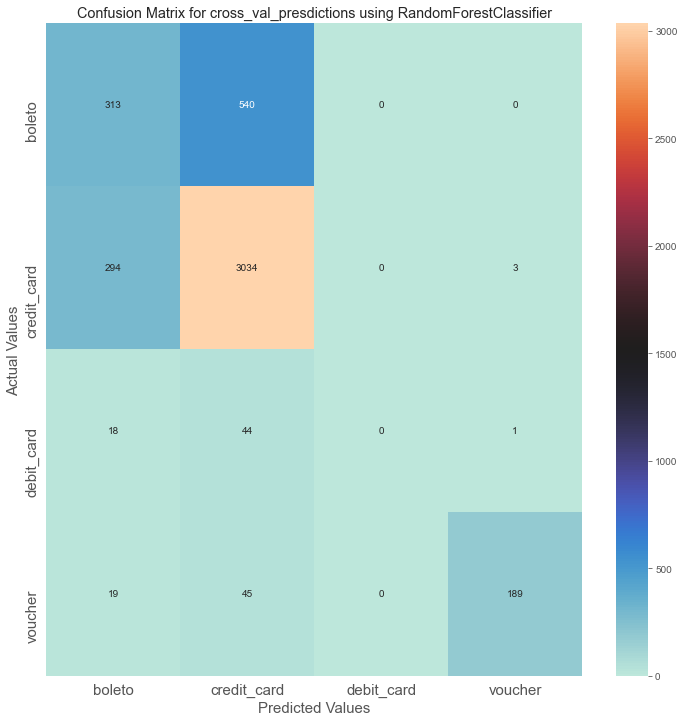

  payment_type  f1_measure
0       boleto        0.42
1  credit_card        0.87
2   debit_card        0.00
3      voucher        0.85


In [67]:
from sklearn.metrics import f1_score, confusion_matrix


# run final randomforest using these new settings

cv = StratifiedShuffleSplit(n_splits=10,test_size = 0.3, train_size = 0.7, random_state=42) #note default is 10 splits!

# final model 
# {'criterion': 'gini', 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 25, 'n_estimators': 200}
rfc = RandomForestClassifier(n_estimators = 200, criterion = 'gini',
                             min_samples_split = 25, min_samples_leaf = 1,
                             max_features = 5, random_state=42)

scores = cross_val_score(rfc, X_train_rfc_feats, y_train_rfc_proc, cv=10, scoring='f1_weighted')

rfc.fit(X_train_rfc_feats, y_train_rfc_proc)

yhat_rfc = cross_val_predict(rfc,X_test_rfc_feats,y_test_rfc_proc, cv=10)

f1_rfc = f1_score(y_test_rfc_proc, yhat_rfc, average=None)


labels = ['boleto','credit_card','debit_card','voucher']
conf_rfc = confusion_matrix(le.inverse_transform(y_test_rfc_proc), le.inverse_transform(yhat_rfc), labels=labels)

# plot results in a heatmap
f, ax = plt.subplots(figsize=(12,12))

sns.heatmap(conf_rfc, annot=True, fmt='g', ax=ax, cmap='icefire')

ax.set_xlabel('Predicted Values', size=15)
ax.set_ylabel('Actual Values', size=15)
ax.set_title('Confusion Matrix for cross_val_presdictions using RandomForestClassifier')
ax.xaxis.set_ticklabels(labels, size=15)
ax.yaxis.set_ticklabels(labels, size=15)
plt.show()

fmeasure_rfc = pd.DataFrame({'payment_type':labels,
                         'f1_measure': f1_rfc})
print(fmeasure_rfc)

     